In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Used Kaggle Notebook for the computational resources it provides

/kaggle/input/chess-games/chess_games.csv


In [2]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.7 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488493 sha256=0ca6624f673b208cfa0722e232807a5bd7b0665e223f35113f32abeb72b54122
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns
from pyspark.ml.feature import StringIndexer
from pyspark.sql import SQLContext, SparkSession
import sys
import os
import shutil
from sklearn.metrics import classification_report

In [5]:
from pyspark.sql.functions import count, countDistinct, length, hour, year, date_format, desc, dayofweek, col, month, min, max, when, isnan, isnull, size, split, expr, udf, lit, regexp_extract, array, broadcast, to_date
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType, StringType
from pyspark.ml.linalg import DenseMatrix, Vectors
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import MinMaxScaler, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, MultilabelClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics


In [6]:
spark = SparkSession.builder \
    .appName("Lichess Analysis").getOrCreate()

# Adjust Spark log level to save space
spark.sparkContext.setLogLevel("ERROR") 

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/07/20 16:21:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [7]:
sqlCtx = SQLContext(spark)

# if unusable in the future, use the spark session directly, like "query = spark.sql()"

/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


# Data Description and Preparation

In [8]:
path_games = "/kaggle/input/chess-games/chess_games.csv"
df_games = spark.read.csv(path_games, header='true', inferSchema='true')

In [8]:
df_games.printSchema()

root
 |-- Event: string (nullable = true)
 |-- White: string (nullable = true)
 |-- Black: string (nullable = true)
 |-- Result: string (nullable = true)
 |-- UTCDate: string (nullable = true)
 |-- UTCTime: timestamp (nullable = true)
 |-- WhiteElo: integer (nullable = true)
 |-- BlackElo: integer (nullable = true)
 |-- WhiteRatingDiff: double (nullable = true)
 |-- BlackRatingDiff: double (nullable = true)
 |-- ECO: string (nullable = true)
 |-- Opening: string (nullable = true)
 |-- TimeControl: string (nullable = true)
 |-- Termination: string (nullable = true)
 |-- AN: string (nullable = true)



### Duplicate Assessment

In [9]:
original_count = df_games.count()
deduplicated_count = df_games.dropDuplicates().count()

num_duplicates = original_count - deduplicated_count

print(f'There are {num_duplicates} duplicates in the dataset')

There are 1 duplicates in the dataset


In [9]:
# Removed

df_games = df_games.dropDuplicates()

### Checking Missing Values

In [49]:
# Counts and displays the number of missing values for each column
missing = df_games.select([count(when(isnull(c), c)).alias(c) for c in df_games.columns]).show()

+-----+-----+-----+------+-------+-------+--------+--------+---------------+---------------+---+-------+-----------+-----------+---+
|Event|White|Black|Result|UTCDate|UTCTime|WhiteElo|BlackElo|WhiteRatingDiff|BlackRatingDiff|ECO|Opening|TimeControl|Termination| AN|
+-----+-----+-----+------+-------+-------+--------+--------+---------------+---------------+---+-------+-----------+-----------+---+
|    0|    0|    0|     0|      0|      0|       0|       0|           4668|           4668|  0|      0|          0|          0|  0|
+-----+-----+-----+------+-------+-------+--------+--------+---------------+---------------+---+-------+-----------+-----------+---+



In [10]:
# Filters out records with `WhiteRatingDiff` or `BlackRatingDiff` null. 
df_games = df_games.filter(
    col('WhiteRatingDiff').isNotNull() | 
    col('BlackRatingDiff').isNotNull()
)

In [51]:
# Removed
missing = df_games.select([count(when(isnull(c), c)).alias(c) for c in df_games.columns]).show()

+-----+-----+-----+------+-------+-------+--------+--------+---------------+---------------+---+-------+-----------+-----------+---+
|Event|White|Black|Result|UTCDate|UTCTime|WhiteElo|BlackElo|WhiteRatingDiff|BlackRatingDiff|ECO|Opening|TimeControl|Termination| AN|
+-----+-----+-----+------+-------+-------+--------+--------+---------------+---------------+---+-------+-----------+-----------+---+
|    0|    0|    0|     0|      0|      0|       0|       0|              0|              0|  0|      0|          0|          0|  0|
+-----+-----+-----+------+-------+-------+--------+--------+---------------+---------------+---+-------+-----------+-----------+---+



### Feature Engineering

In [52]:
# Let's take a look at AN, to see if we can estrapolate number of moves in some way

first_row = df_games.first()
first_value = first_row["AN"]
print("Using first():", first_value)


Using first(): 1. e4 d5 2. Qf3 dxe4 3. Qxe4 Nc6 4. Qf3 Nf6 5. c3 Bg4 6. Qg3 e6 7. d4 Bd6 8. Qh4 h6 9. h3 Bf5 10. f4 Qe7 11. Bb5 Qd7 12. Nf3 O-O-O 13. O-O a6 14. Be2 Ne4 15. Ne5 Bxe5 16. fxe5 g5 17. Qh5 Ng3 18. Qf3 Nxf1 19. Qxf1 Rhg8 20. Nd2 b5 21. Nb3 Bc2 22. Nc5 Qd5 23. Nxa6 Nxd4 24. Bxb5 Nxb5 25. Nb4 Qc5+ 26. Kh1 Qxe5 27. Nc6 Qe4 28. Nxd8 Rxd8 29. Qxb5 Rd1+ 30. Kh2 Bd3 31. Qc5 Bf1 32. Be3 Qxg2# 0-1


In [11]:
# I came up with this function: remove the last three indices as they simply are the result
# Split the string being careful about the fact that numbers are concatenated with a point 
# Take the highest number and multiply it by 2, and check if after it there are one or two elements
# if it has two, no action, if only one move follows it, remove one by the total count. 

def calculate_num_moves(moves_str):
    # Remove the last three indices (result part) and split
    moves_str = moves_str[:-3]
    moves_list = moves_str.split()
    
    # Initialize "highest" to store the highest number in the string
    highest = 0
    
    # Iterate through the moves_list to find the final "highest" number
    for move in moves_list:
        # Extract the move number (before the dot)
        try:
            move_num = int(move.split('.')[0])
            if move_num > highest:
                highest = move_num
        except ValueError:
            # Ignore moves that are not integers (like "e4", "Qxg5", etc.)
            continue
    
    # Calculate the number of moves based on "highest" * 2
    num_moves = highest * 2
    
    # Find the index of the highest move in the moves_list
    highest_str = f"{highest}."
    highest_index = None
    for i, move in enumerate(moves_list):
        if move.startswith(highest_str):
            highest_index = i
            break
    
    # Adjust num_moves by subtracting one if only one element follows the "highest" number
   
    if highest_index == len(moves_list) - 2:
            num_moves -= 1
    
    return num_moves


In [12]:
# Register the function as a UDF
calculate_num_moves_udf = udf(calculate_num_moves, IntegerType())

df_with_moves_count = df_games.withColumn("n_moves", calculate_num_moves_udf("AN"))

# Show the results (check for correctness)
df_with_moves_count.select("AN", "n_moves").show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [13]:
## It works, we can go for it
df_games = df_with_moves_count

In [56]:
df_games.printSchema()

root
 |-- Event: string (nullable = true)
 |-- White: string (nullable = true)
 |-- Black: string (nullable = true)
 |-- Result: string (nullable = true)
 |-- UTCDate: string (nullable = true)
 |-- UTCTime: timestamp (nullable = true)
 |-- WhiteElo: integer (nullable = true)
 |-- BlackElo: integer (nullable = true)
 |-- WhiteRatingDiff: double (nullable = true)
 |-- BlackRatingDiff: double (nullable = true)
 |-- ECO: string (nullable = true)
 |-- Opening: string (nullable = true)
 |-- TimeControl: string (nullable = true)
 |-- Termination: string (nullable = true)
 |-- AN: string (nullable = true)
 |-- n_moves: integer (nullable = true)



In [57]:
# Verify column values to see search for some other feature engineering
df_games.limit(10).toPandas()

,Event,White,Black,Result,UTCDate,UTCTime,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,ECO,Opening,TimeControl,Termination,AN,n_moves
0,Blitz,frustrator,Secondoftwo,0-1,2016.06.30,2024-07-17 22:00:57,1667,1966,-4.0,3.0,B01,Scandinavian Defense,120+2,Normal,1. e4 d5 2. Qf3 dxe4 3. Qxe4 Nc6 4. Qf3 Nf6 5....,64
1,Bullet,tiltCHIMP,zokiMKD,0-1,2016.06.30,2024-07-17 22:02:02,1799,1976,-7.0,6.0,A43,Old Benoni Defense,60+0,Normal,1. d4 c5 2. e3 cxd4 3. exd4 d5 4. Nf3 Nc6 5. c...,30
2,Bullet,hilllel,liget,0-1,2016.06.30,2024-07-17 22:06:43,1392,1311,-13.0,13.0,A30,English Opening: Symmetrical Variation,120+1,Normal,1. c4 { [%eval 0.08] } 1... c5 { [%eval 0.15] ...,54
3,Blitz,Cave_caballum,jacksssparrow,0-1,2016.06.30,2024-07-17 22:09:36,1641,1621,-12.0,12.0,B23,Sicilian Defense: Closed #2,300+0,Normal,1. e4 c5 2. Nc3 e6 3. g3 d6 4. Bg2 Nf6 5. d3 N...,28
4,Bullet,potsy722,Aristi,1-0,2016.06.30,2024-07-17 22:11:16,1895,1724,5.0,-6.0,C34,"King's Gambit Accepted, MacLeod Defense",60+0,Time forfeit,1. e4 e5 2. f4 Nc6 3. Nf3 exf4 4. d4 d5 5. exd...,35
5,Blitz,mickael51,d4bestbytest,1-0,2016.06.30,2024-07-17 22:13:17,2225,1985,4.0,-4.0,C10,French Defense: Paulsen Variation,180+0,Normal,1. d4 e6 2. e4 d5 3. Nc3 Nc6 4. e5 Nge7 5. Be3...,53
6,Blitz,pelapu,Quentinovich,0-1,2016.06.30,2024-07-17 22:13:48,2074,2120,-9.0,9.0,B01,Scandinavian Defense: Modern Variation #2,180+0,Normal,1. e4 d5 2. exd5 Nf6 3. Bb5+ Bd7 4. Bc4 b5 5. ...,36
7,Blitz,sevyan,kriss,0-1,2016.06.30,2024-07-17 22:15:23,1537,1548,-11.0,11.0,C00,French Defense: Knight Variation,300+0,Normal,1. e4 e6 2. Nf3 d6 3. Bc4 h6 4. d3 a6 5. a4 b6...,66
8,Blitz,kemosabee,Hasonahabib,0-1,2016.06.30,2024-07-17 22:15:57,1569,1602,-10.0,10.0,A43,Old Benoni Defense,300+0,Time forfeit,1. d4 c5 2. Bf4 Nc6 3. e3 e6 4. a3 Qb6 5. Nc3 ...,98
9,Blitz,Squalito,freewildman,1/2-1/2,2016.06.30,2024-07-17 22:16:55,1748,1801,2.0,-1.0,B40,Sicilian Defense: Delayed Alapin Variation,180+2,Normal,1. e4 c5 2. Nf3 e6 3. c3 Nc6 4. d4 cxd4 5. cxd...,116


#### We now need to work on "Result", it should be mapped. Then an important task will be creating new features, such as "w_opening_n_games", "b_opening_n_games", "w_opening_performance", "b_opening_performance", "w_timecontrol_n_games", "b_timecontrol_n_games", "w_timecontrol_performance", "b_timecontrol_performance", which I will later explain. 

In [14]:
# Unique values are these four: '1-0', '0-1', "1/2-1/2" and "*" 
# Let's remove the "*" values, and let's map 1-0 (White won) as 1, 1/2-1/2 (draw) as 0
# And 0-1 (Black Won) as 2. This will prove crucial for our successive Classification task 

df_filtered = df_games.filter(df_games['Result'] != '*')
df_games = df_filtered.withColumn(
    'Result',
    when(df_filtered['Result'] == '1-0', 1)
    .when(df_filtered['Result'] == '0-1', -1)
    .when(df_filtered['Result'] == '1/2-1/2', 0)
)

# And check the correctness of our code 
df_games.groupBy('Result').count().show()


+------+-------+
|Result|  count|
+------+-------+
|    -1|2901034|
|     1|3111715|
|     0| 238763|
+------+-------+



In [15]:
# Ok now let's group by "White", and let's find some aggregate values. 
# First off let's find the number of games for each opening ("ECO") played by each White user ("White")
# Let's also rename "count" into "w_opening_n_games"

df_grouped1 = df_filtered.groupBy('White', 'ECO').count().withColumnRenamed("count", "w_opening_n_games")
df_grouped1.show()

+--------------+---+-----------------+
|         White|ECO|w_opening_n_games|
+--------------+---+-----------------+
|      smiittyy|D00|              119|
|     blixten16|A00|               22|
|          Efyx|B32|                4|
|      CIROPERU|B10|                2|
|        piwot3|B23|              233|
|          luuu|C26|                6|
|      renr8360|B07|                3|
|   marianoe155|A52|                1|
|      egemen10|C69|                2|
|     timmy2007|A40|               62|
|IMaDirtyPLAYER|A41|                1|
|         grelf|D35|               10|
|       gendime|B50|                5|
|      pjesak87|E60|                3|
|     borissm11|B10|               30|
|        karat2|B00|               85|
|   rafaymartin|C50|               15|
|          inex|B00|               31|
|     rekekles1|B06|                7|
|   yalicapkini|C44|               21|
+--------------+---+-----------------+
only showing top 20 rows



In [16]:
# Let's add this information in our df_games dataframe, with column "w_opening_n_games"
df_games = df_games.join(df_grouped1, on=['White', 'ECO'], how='left')

In [62]:
df_games.show()

+----------------+---+-----------+-----------------+------+----------+-------------------+--------+--------+---------------+---------------+--------------------+-----------+------------+--------------------+-------+-----------------+
|           White|ECO|      Event|            Black|Result|   UTCDate|            UTCTime|WhiteElo|BlackElo|WhiteRatingDiff|BlackRatingDiff|             Opening|TimeControl| Termination|                  AN|n_moves|w_opening_n_games|
+----------------+---+-----------+-----------------+------+----------+-------------------+--------+--------+---------------+---------------+--------------------+-----------+------------+--------------------+-------+-----------------+
|          AAM777|A01| Classical |              EDF|     1|2016.06.30|2024-07-17 22:14:43|    1724|    1457|            5.0|           -4.0| Nimzo-Larsen Attack|      600+0|      Normal|1. b3 e6 2. Bb2 b...|     11|              272|
|       ALMADINAH|A13|    Bullet |      M3rC3L_CCas|    -1|2016.

In [17]:
# Count the number of records in df_games to ensure all proceeded as planned
record_count = df_games.count()

print(f"Number of records in df_result: {record_count}")

Number of records in df_result: 6251512


In [17]:
# Let's do the same thing for "Black" and "b_opening_n_games"
df_grouped2 = df_games.groupBy('Black', 'ECO').count().withColumnRenamed("count", "b_opening_n_games")
df_games = df_games.join(df_grouped2, on=['Black', 'ECO'], how='left')

In [18]:
# Now with a similar process, let's extract "w_opening_performance" and "b_opening_performance"
# Simply intead of a count(), let's sum up the results, (1, 0, -1), so we will have negative and 
# positive values, depending on the "performances" on each opening for each player.

# Group by White player and ECO, summing "Result"
df_w_performance = df_games.groupBy('White', 'ECO') \
                              .agg(F.sum(F.col('Result')).alias('w_opening_performance'))
                              
df_games = df_games.join(df_w_performance, on=['White', 'ECO'], how='left')                             

In [19]:
# Let's do the same for "Black"
df_b_performance = df_games.groupBy('Black', 'ECO') \
                              .agg(F.sum(F.col('Result')).alias('b_opening_performance'))
                                                        
df_games = df_games.join(df_b_performance, on=['Black', 'ECO'], how='left')   

In [22]:
# Now let's see if the "Event" column needs some preprocessing 

df_games.groupBy('Event').count().show()

+--------------------+-------+
|               Event|  count|
+--------------------+-------+
|          Classical |1509068|
|              Blitz |     12|
|  Bullet tournament | 546617|
|   Blitz tournament | 472070|
| Classical tourna...| 165506|
|             Bullet |1197652|
|Classical tournam...|      1|
|     Correspondence |  22211|
|              Blitz |2338363|
|   Blitz tournament |      1|
|          Classical |      7|
|             Bullet |      2|
|  Bullet tournament |      2|
+--------------------+-------+



#### There is some inconsistency with data entry, however since Blitz/Bullet/Classical tournaments on Lichess are pretty much the same as ranked games, we will map all the events into "Correspondence", "Rapid/Classical", "Blitz", "Bullet", and we will rename the column "TimeControlName" (to differentiate from other column "TimeControl")

In [20]:
# Let's remove leading and traling whitespaces, and convert all to lower case 

df_games = df_games.withColumn('Event', F.trim(F.col('Event')))
df_games = df_games.withColumn('Event', F.lower(F.col('Event')))

# Let's define a personalized function to map event names based on patterns
def map_event(event):
    event = event.strip().lower()
    if 'classical' in event:
        return 'Rapid/Classical'
    elif 'blitz' in event:
        return 'Blitz'
    elif 'bullet' in event:
        return 'Bullet'
    elif 'correspondence' in event:
        return 'Correspondence'
    else:
        return 'Other'


# Create a UDF to map event names to categories
map_event_udf = F.udf(map_event, StringType())

# Let's apply it and let's drop the column previous "Event" feature
df_games = df_games.withColumn('TimeControlName', map_event_udf(F.col('Event')))
df_games = df_games.drop('Event')

In [24]:
df_games.groupBy('TimeControlName').count().show()

+---------------+-------+
|TimeControlName|  count|
+---------------+-------+
|         Bullet|1744273|
|Rapid/Classical|1674582|
|          Blitz|2810446|
| Correspondence|  22211|
+---------------+-------+



#### Now we can go on and create probably the last features we will use in our Classification Task.  "w_timecontrol_n_games", "b_timecontrol_n_games" "w_timecontrol_performance", "b_timecontrol_performance". Idea is the same we used for openings, but this time we are going to group by "TimeControlName".  

In [21]:
# Group by White player and TimeControlName to get the count of games
df_w_timecontrol_n_games = df_games.groupBy('White', 'TimeControlName').count() \
                                   .withColumnRenamed("count", "w_timecontrol_n_games")

df_b_timecontrol_n_games = df_games.groupBy('Black', 'TimeControlName').count() \
                                   .withColumnRenamed("count", "b_timecontrol_n_games")

# Group by White player and TimeControlName to get the sum of results (performance)
df_w_timecontrol_performance = df_games.groupBy('White', 'TimeControlName') \
                                       .agg(F.sum(F.col('Result')).alias('w_timecontrol_performance'))

df_b_timecontrol_performance = df_games.groupBy('Black', 'TimeControlName') \
                                       .agg(F.sum(F.col('Result')).alias('b_timecontrol_performance'))

In [22]:
# Join the grouped DataFrames back to the original DataFrame
df_games = df_games \
    .join(df_w_timecontrol_n_games, on=['White', 'TimeControlName'], how='left') \
    .join(df_b_timecontrol_n_games, on=['Black', 'TimeControlName'], how='left') \
    .join(df_w_timecontrol_performance, on=['White', 'TimeControlName'], how='left') \
    .join(df_b_timecontrol_performance, on=['Black', 'TimeControlName'], how='left')

In [73]:
df_games.show()

+-----------------+---------------+----------------+---+------+----------+-------------------+--------+--------+---------------+---------------+--------------------+-----------+------------+--------------------+-------+-----------------+-----------------+---------------------+---------------------+---------------------+---------------------+-------------------------+-------------------------+
|            Black|TimeControlName|           White|ECO|Result|   UTCDate|            UTCTime|WhiteElo|BlackElo|WhiteRatingDiff|BlackRatingDiff|             Opening|TimeControl| Termination|                  AN|n_moves|w_opening_n_games|b_opening_n_games|w_opening_performance|b_opening_performance|w_timecontrol_n_games|b_timecontrol_n_games|w_timecontrol_performance|b_timecontrol_performance|
+-----------------+---------------+----------------+---+------+----------+-------------------+--------+--------+---------------+---------------+--------------------+-----------+------------+------------------

In [28]:
df_games.count()

6251512

In [75]:
df_games.printSchema()

root
 |-- Black: string (nullable = true)
 |-- TimeControlName: string (nullable = true)
 |-- White: string (nullable = true)
 |-- ECO: string (nullable = true)
 |-- Result: integer (nullable = true)
 |-- UTCDate: string (nullable = true)
 |-- UTCTime: timestamp (nullable = true)
 |-- WhiteElo: integer (nullable = true)
 |-- BlackElo: integer (nullable = true)
 |-- WhiteRatingDiff: double (nullable = true)
 |-- BlackRatingDiff: double (nullable = true)
 |-- Opening: string (nullable = true)
 |-- TimeControl: string (nullable = true)
 |-- Termination: string (nullable = true)
 |-- AN: string (nullable = true)
 |-- n_moves: integer (nullable = true)
 |-- w_opening_n_games: long (nullable = true)
 |-- b_opening_n_games: long (nullable = true)
 |-- w_opening_performance: long (nullable = true)
 |-- b_opening_performance: long (nullable = true)
 |-- w_timecontrol_n_games: long (nullable = true)
 |-- b_timecontrol_n_games: long (nullable = true)
 |-- w_timecontrol_performance: long (nullable

In [23]:
## Let's transform UTCDate from string to Date format 

df_games = df_games.withColumn("UTCDate", to_date(col("UTCDate"), "yyyy.MM.dd"))


In [30]:
# Termination is already clean for analysis, no need to further processing 
df_games.groupBy('Termination').count().show()

+----------------+-------+
|     Termination|  count|
+----------------+-------+
|       Abandoned|  13286|
|Rules infraction|    124|
|    Time forfeit|2010178|
|          Normal|4227924|
+----------------+-------+



# Data Understanding 

In [78]:
print(f'We have data in a range from {df_games.select(F.min("UTCDate")).collect()[0][0]} to {df_games.select((F.max("UTCDate"))).collect()[0][0]}')

We have data in a range from 2016-06-30 to 2016-07-31


### Numerical features distribution

>>> Plotting distribution for WhiteElo


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


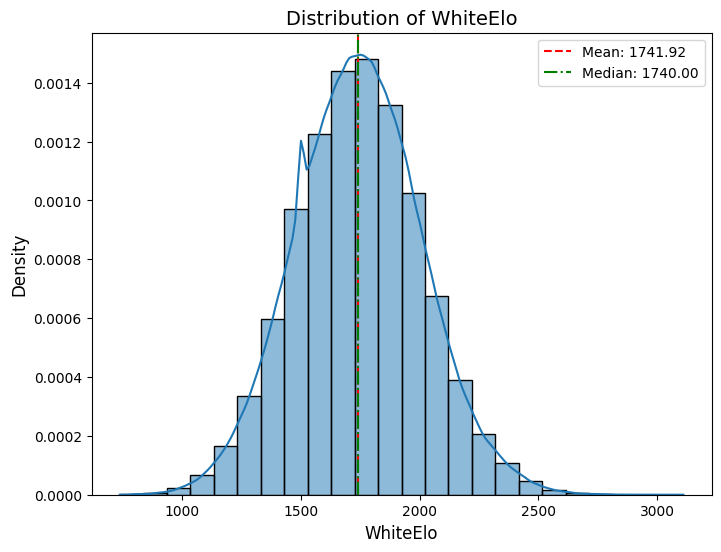

>>> Plotting distribution for BlackElo


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


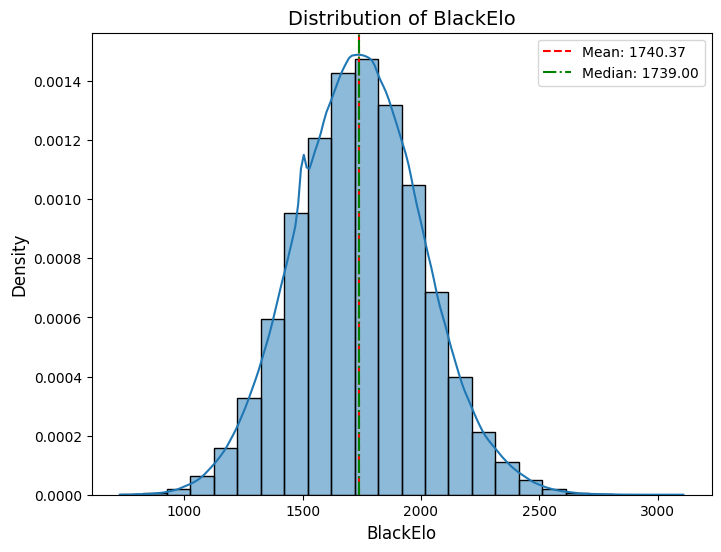

>>> Plotting distribution for WhiteRatingDiff


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


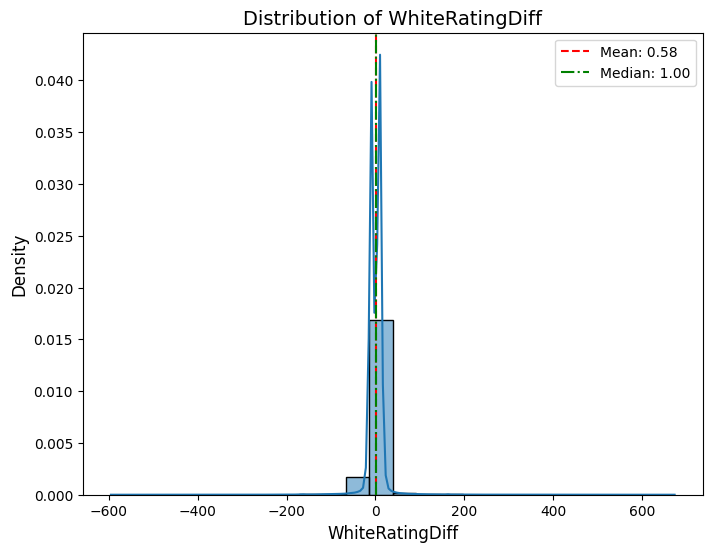

>>> Plotting distribution for BlackRatingDiff


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


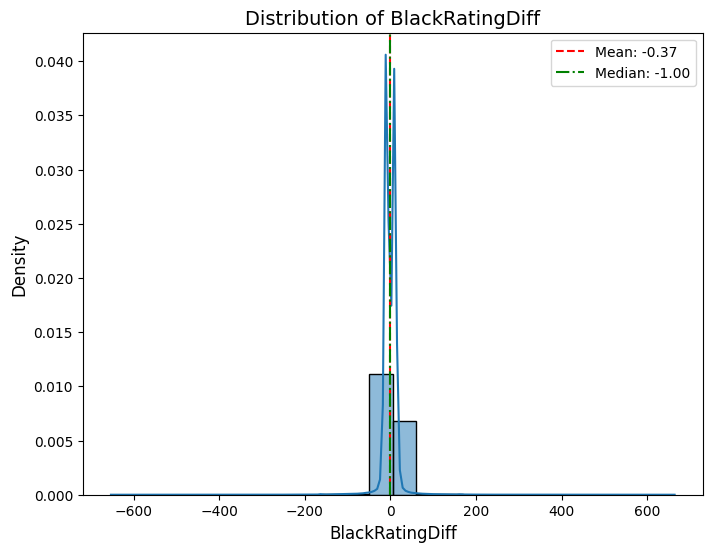

>>> Plotting distribution for n_moves


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


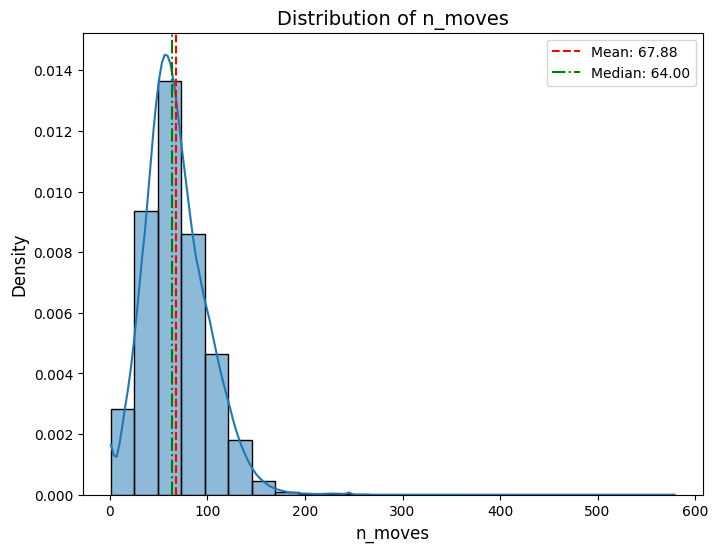

>>> Plotting distribution for w_opening_n_games


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


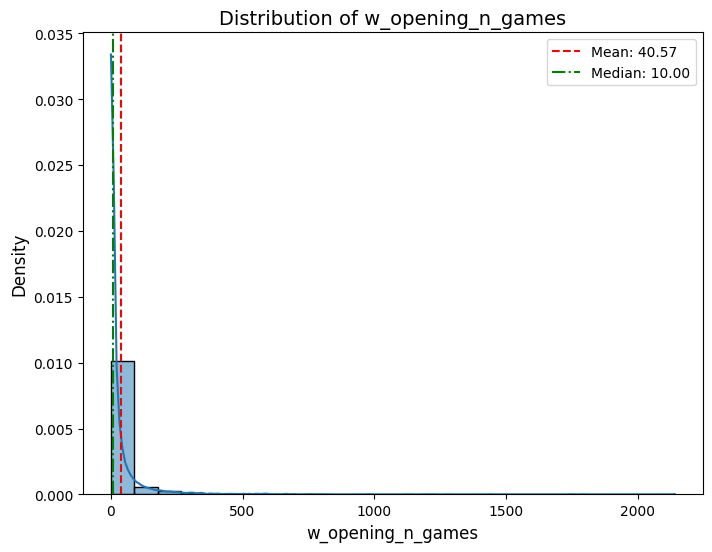

>>> Plotting distribution for b_opening_n_games


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


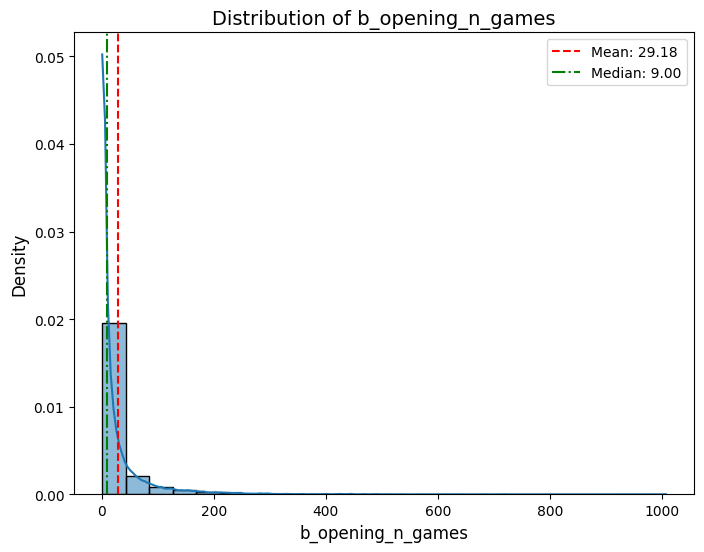

>>> Plotting distribution for w_opening_performance


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


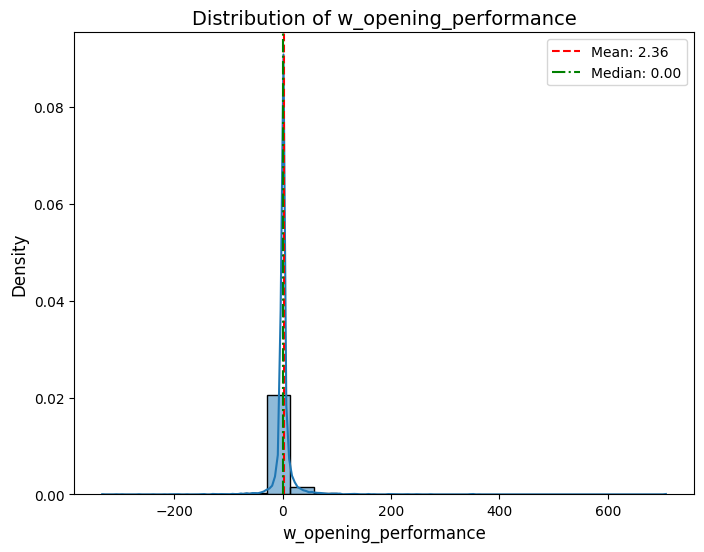

>>> Plotting distribution for b_opening_performance


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


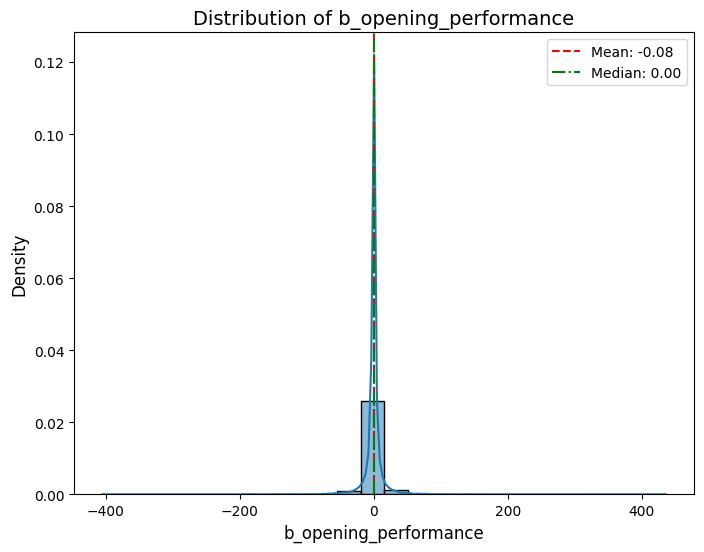

>>> Plotting distribution for w_timecontrol_n_games


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


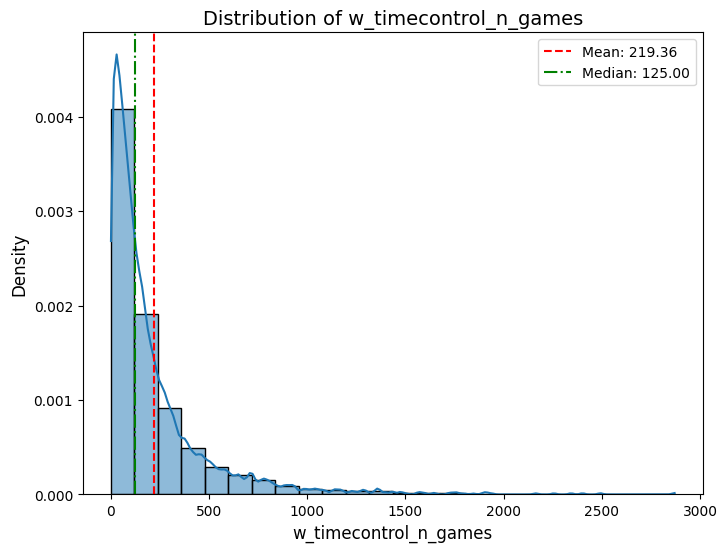

>>> Plotting distribution for b_timecontrol_n_games


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


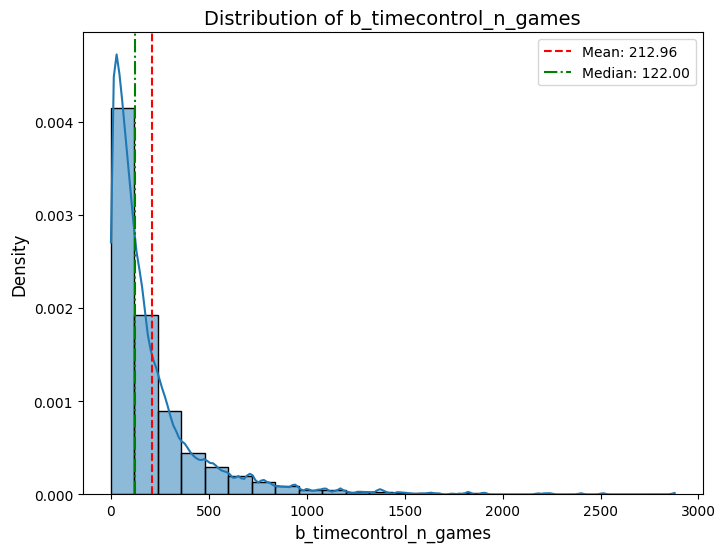

>>> Plotting distribution for w_timecontrol_performance


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


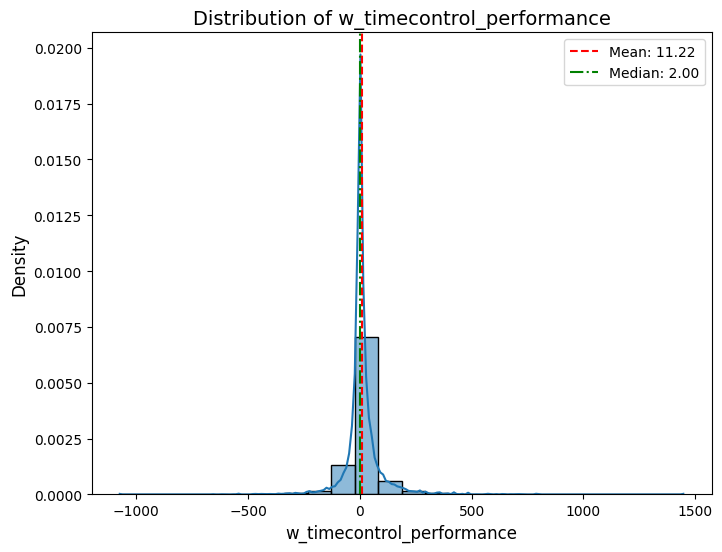

>>> Plotting distribution for b_timecontrol_performance


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


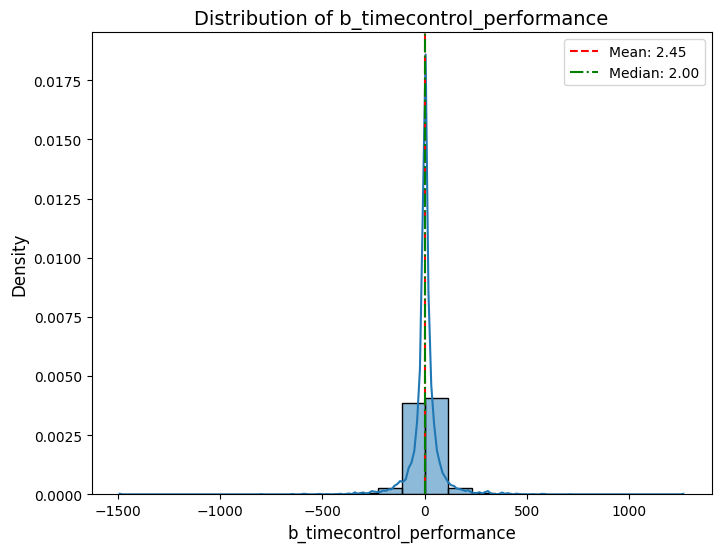

In [24]:
# Create a Temporary View
df_games.createOrReplaceTempView("chess")

# Columns to plot frequency distributions
xy_columns = [
    'WhiteElo', 'BlackElo', 'WhiteRatingDiff', 'BlackRatingDiff', 
    'n_moves', 'w_opening_n_games', 'b_opening_n_games', 'w_opening_performance', 
    'b_opening_performance', 'w_timecontrol_n_games', 'b_timecontrol_n_games', 
    'w_timecontrol_performance', 'b_timecontrol_performance'
]

# Define function to plot histograms for a subset of columns
def plot_histograms(columns):
    for col in columns:
        print(f">>> Plotting distribution for {col}")

        # Convert Spark DataFrame column to Pandas Series
        data = df_games.select(col).toPandas()[col]

        # Create figure and axis
        plt.figure(figsize=(8, 6))
        ax = sns.histplot(data, kde=True, stat="density", bins=24)  # KDE enabled with 24 bins

        # Calculate mean and median
        mean_value = np.mean(data)
        median_value = np.median(data)

        # Plot mean and median lines
        ax.axvline(mean_value, color='r', linestyle='--', label=f'Mean: {mean_value:.2f}')
        ax.axvline(median_value, color='g', linestyle='-.', label=f'Median: {median_value:.2f}')

        # Set labels and title
        plt.xlabel(col, size=12)
        plt.ylabel('Density', size=12)
        plt.title(f'Distribution of {col}', size=14)
        plt.legend()

        # Show plot
        plt.show()

# Split columns into groups of 4 and plot histograms sequentially
for i in range(0, len(xy_columns), 4):
    plot_histograms(xy_columns[i:i+4])

### Categorical features distribution

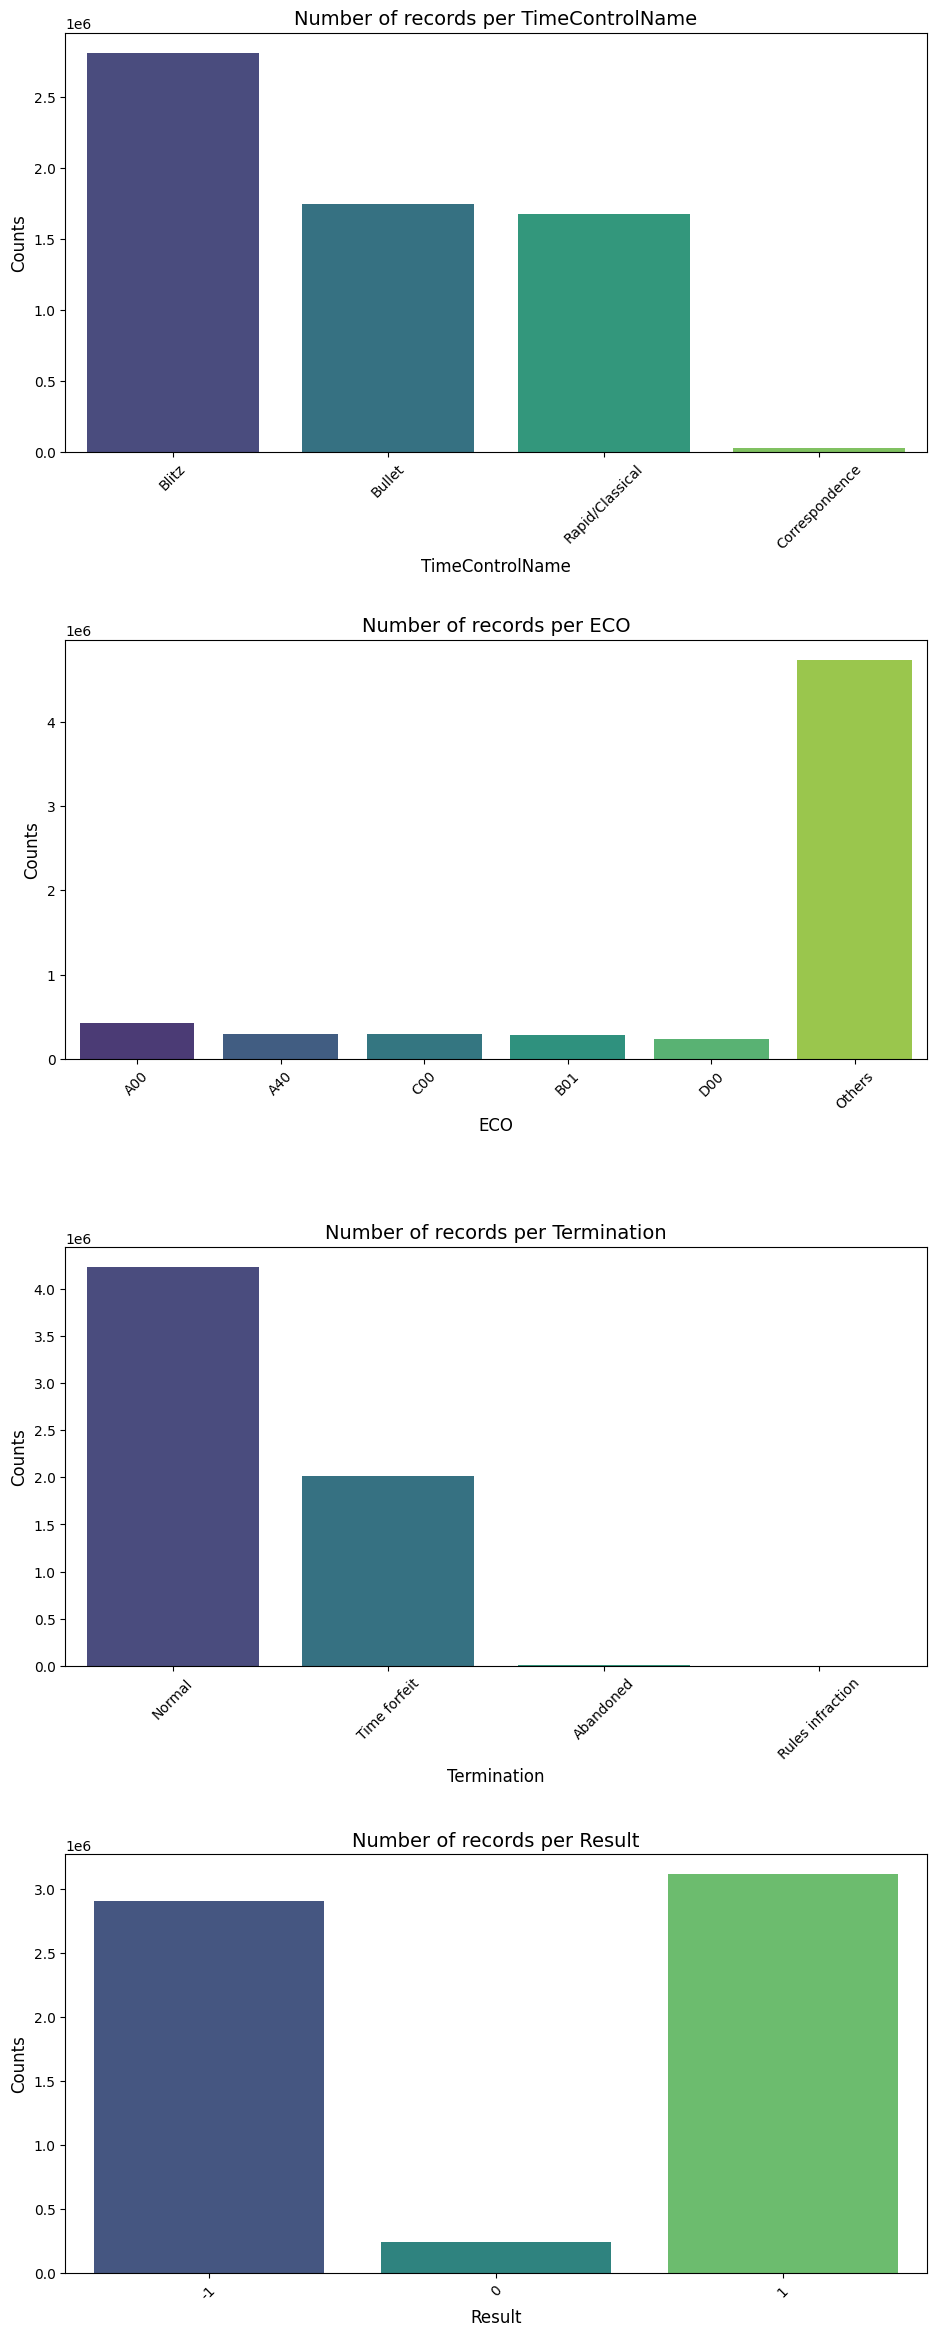

In [63]:
# Categorical features to plot
categorical_features = ['TimeControlName', 'ECO', 'Termination', 'Result']

# Count records for each categorical feature
category_counts = {}
for feature in categorical_features:
    # Calculate counts
    counts = df_games.groupBy(feature).count().orderBy('count', ascending=False).toPandas()
    
    # Limit unique values for ECO to top 10 and aggregate others
    if feature == 'ECO':
        top_eco = counts.head(5)
        others_count = counts.iloc[5:]['count'].sum()
        others_df = pd.DataFrame({'ECO': ['Others'], 'count': [others_count]})
        counts = pd.concat([top_eco, others_df])
    
    category_counts[feature] = counts

# Plotting
fig, axes = plt.subplots(len(categorical_features), 1, figsize=(10, 6 * len(categorical_features)))

for i, feature in enumerate(categorical_features):
    ax = axes[i]
    
    # Plotting bar plot
    sns.barplot(x=feature, y="count", data=category_counts[feature], ax=ax, palette='viridis')
    ax.set_xlabel(feature, size=12)
    ax.set_ylabel("Counts", size=12)
    ax.set_title(f"Number of records per {feature}", size=14)
    ax.tick_params(axis='x', labelrotation=45)
        
plt.tight_layout(pad=3.0)
plt.show()

### Line/Bar Plots for Time/Date data

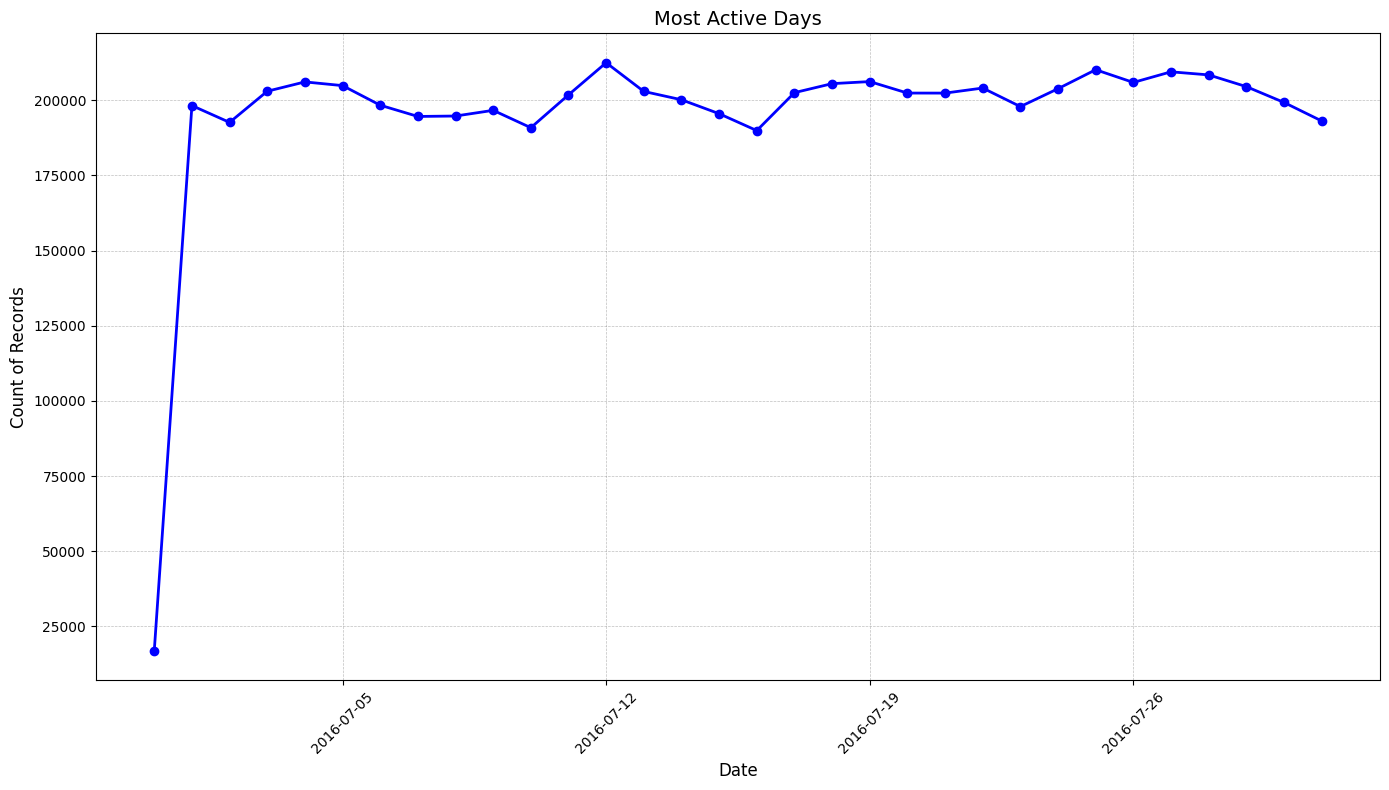

In [64]:
# Count records per UTCDate
date_counts = df_games.groupBy('UTCDate').count().orderBy('UTCDate').toPandas()

# Plotting
plt.figure(figsize=(14, 8))
plt.plot(date_counts['UTCDate'], date_counts['count'], marker='o', linestyle='-', color='b', linewidth=2)

# Formatting the x-axis dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))  # Show ticks every 7 days

plt.xlabel('Date', size=12)
plt.ylabel('Count of Records', size=12)
plt.title('Most Active Days', size=14)
plt.xticks(rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
plt.tight_layout()
plt.show()

/tmp/ipykernel_34/3966533442.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_intervals = pd.date_range(start=time_counts['UTCTime'].min(), end=time_counts['UTCTime'].max() + pd.Timedelta(hours=1), freq='H')


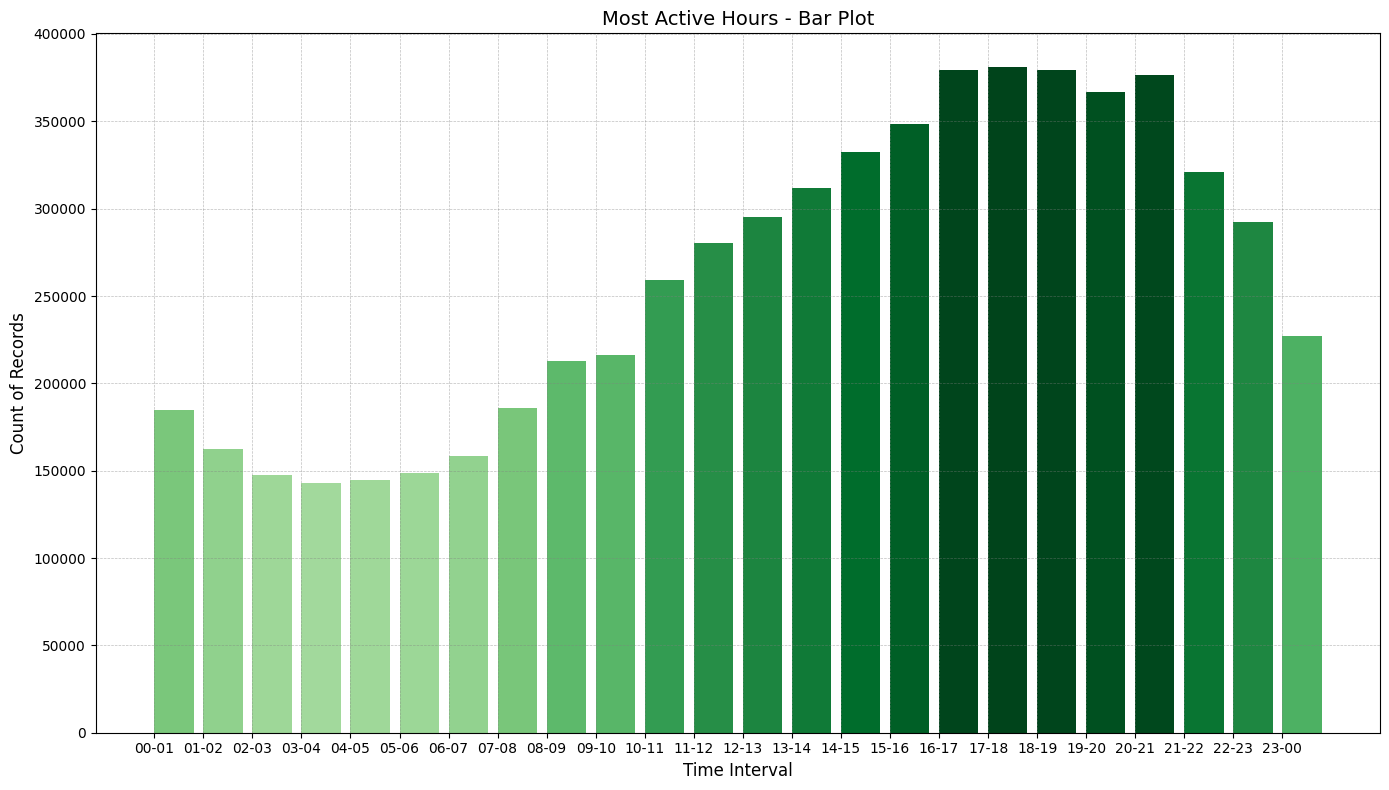

In [65]:
# Count records per UTCTime
time_counts = df_games.groupBy('UTCTime').count().orderBy('UTCTime').toPandas()

# Define the time intervals for the bars
time_intervals = pd.date_range(start=time_counts['UTCTime'].min(), end=time_counts['UTCTime'].max() + pd.Timedelta(hours=1), freq='H')

# Bin UTCTime into time intervals
time_counts['TimeInterval'] = pd.cut(time_counts['UTCTime'], bins=time_intervals, right=False, labels=False)

# Aggregate counts per time interval
time_counts_agg = time_counts.groupby('TimeInterval')['count'].sum().reset_index()


plt.figure(figsize=(14, 8))

# Calculate the maximum count for color scaling
max_count = time_counts_agg['count'].max()

# Define bar colors based on count intensity (darker green for higher counts)
colors = plt.cm.Greens(time_counts_agg['count'] / max_count)

# Plot bars with adjusted x-axis labels
bars = plt.bar(np.arange(len(time_counts_agg)), time_counts_agg['count'], width=0.8, align='edge', color=colors)

# Set x-axis labels as hour intervals
plt.xticks(np.arange(len(time_counts_agg)), [f'{h:02}-{(h+1) % 24:02}' for h in range(len(time_counts_agg))])

plt.xlabel('Time Interval', size=12)
plt.ylabel('Count of Records', size=12)
plt.title('Most Active Hours - Bar Plot', size=14)
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
plt.tight_layout()
plt.show()

### Let's get some insights on Najdorf Sicilian (B90-B99)

In [68]:
# Step 1: Filter for Najdorf Sicilian (ECO codes B90 to B99)
najdorf_df = df_games.filter((df_games['ECO'] >= 'B90') & (df_games['ECO'] <= 'B99'))

# Step 2: Aggregate necessary statistics
najdorf_stats = najdorf_df.agg(
    F.avg('WhiteElo').alias('avg_white_elo'),
    F.avg('BlackElo').alias('avg_black_elo'),
    F.sum('Result').alias('performance_sum'),  
    F.count('*').alias('num_games')
).collect()[0]

# Retrieve necessary statistics
avg_black_elo = najdorf_stats['avg_black_elo']
performance_sum = najdorf_stats['performance_sum']

print(f'Average Najdorf Player (Black) Elo: {avg_black_elo}')
print(f'Performance with Najdorf across all ELO levels: {performance_sum}')


Average Najdorf Player (Black) Elo: 1899.3387631035423
Performance with Najdorf across all ELO levels: -971


In [69]:
# Use when() to categorize BlackElo into bins and create a new column
najdorf_df = najdorf_df.withColumn('BlackEloCategory', 
                                   F.when((F.col('BlackElo') <= 1199), '0-1199')
                                   .when((F.col('BlackElo') >= 1200) & (F.col('BlackElo') < 1400), '1200-1399')
                                   .when((F.col('BlackElo') >= 1400) & (F.col('BlackElo') < 1600), '1400-1599')
                                   .when((F.col('BlackElo') >= 1600) & (F.col('BlackElo') < 1800), '1600-1799')
                                   .when((F.col('BlackElo') >= 1800) & (F.col('BlackElo') < 2000), '1800-1999')
                                   .when((F.col('BlackElo') >= 2000) & (F.col('BlackElo') < 2200), '2000-2199')
                                   .when((F.col('BlackElo') >= 2200) & (F.col('BlackElo') < 2400), '2200-2399')
                                   .when((F.col('BlackElo') >= 2400), '>= 2400'))

# Calculate total number of games played in each ELO group by Black
total_games = (najdorf_df.groupBy('BlackEloCategory')
                         .agg(F.count('*').alias('TotalGames')))
# Calculate win counts for each ELO group by Black
win_counts = (najdorf_df.filter(najdorf_df['Result'] == -1)
                        .groupBy('BlackEloCategory')
                        .agg(F.count('*').alias('WinCount')))

# Calculate win rate (percentage of wins) for each ELO group by Black
win_rate = (win_counts.join(total_games, 'BlackEloCategory')
                      .select('BlackEloCategory', (F.col('WinCount') / F.col('TotalGames') * 100).alias('WinRate'))
                      .fillna(0))

# Calculate total result (sum of Result) for each ELO group by Black
total_result = (najdorf_df.groupBy('BlackEloCategory')
                         .agg(F.sum('Result').alias('TotalResult')))

# Calculate performance per game (average performance) for each ELO group by Black
performance_per_game = (total_result.join(total_games, 'BlackEloCategory')
                                   .withColumn('PerformancePerGame', F.col('TotalResult') / F.col('TotalGames'))
                                   .select('BlackEloCategory', 'PerformancePerGame'))

# Determine which ELO group has the most and least success (w.r.t win rate) for Black in Najdorf Sicilian
most_successful_group = (win_rate.join(performance_per_game, 'BlackEloCategory')
                                 .orderBy(F.desc('WinRate'))
                                 .select('BlackEloCategory')
                                 .first()[0])

least_successful_group = (win_rate.join(performance_per_game, 'BlackEloCategory')
                                 .orderBy(F.asc('WinRate'))
                                 .select('BlackEloCategory')
                                 .first()[0])

# Print the most successful group, its win rate and performance per game
print(f'Most successful Black Elo group in Najdorf Sicilian: {most_successful_group} with a Win Rate of {win_rate.filter(win_rate["BlackEloCategory"] == most_successful_group).collect()[0]["WinRate"]:.2f}% and a PerformancePerGame of {performance_per_game.filter(performance_per_game["BlackEloCategory"] == most_successful_group).collect()[0]["PerformancePerGame"]:.2f}')

# Print the least successful group, its win rate and and performance per game
print(f'Least successful Black Elo group in Najdorf Sicilian: {least_successful_group} with a Win Rate of {win_rate.filter(win_rate["BlackEloCategory"] == least_successful_group).collect()[0]["WinRate"]:.2f}% and a PerformancePerGame of {performance_per_game.filter(performance_per_game["BlackEloCategory"] == least_successful_group).collect()[0]["PerformancePerGame"]:.2f}')

Most successful Black Elo group in Najdorf Sicilian: >= 2400 with a Win Rate of 64.92% and a PerformancePerGame of -0.35


Least successful Black Elo group in Najdorf Sicilian: 1200-1399 with a Win Rate of 36.94% and a PerformancePerGame of 0.23


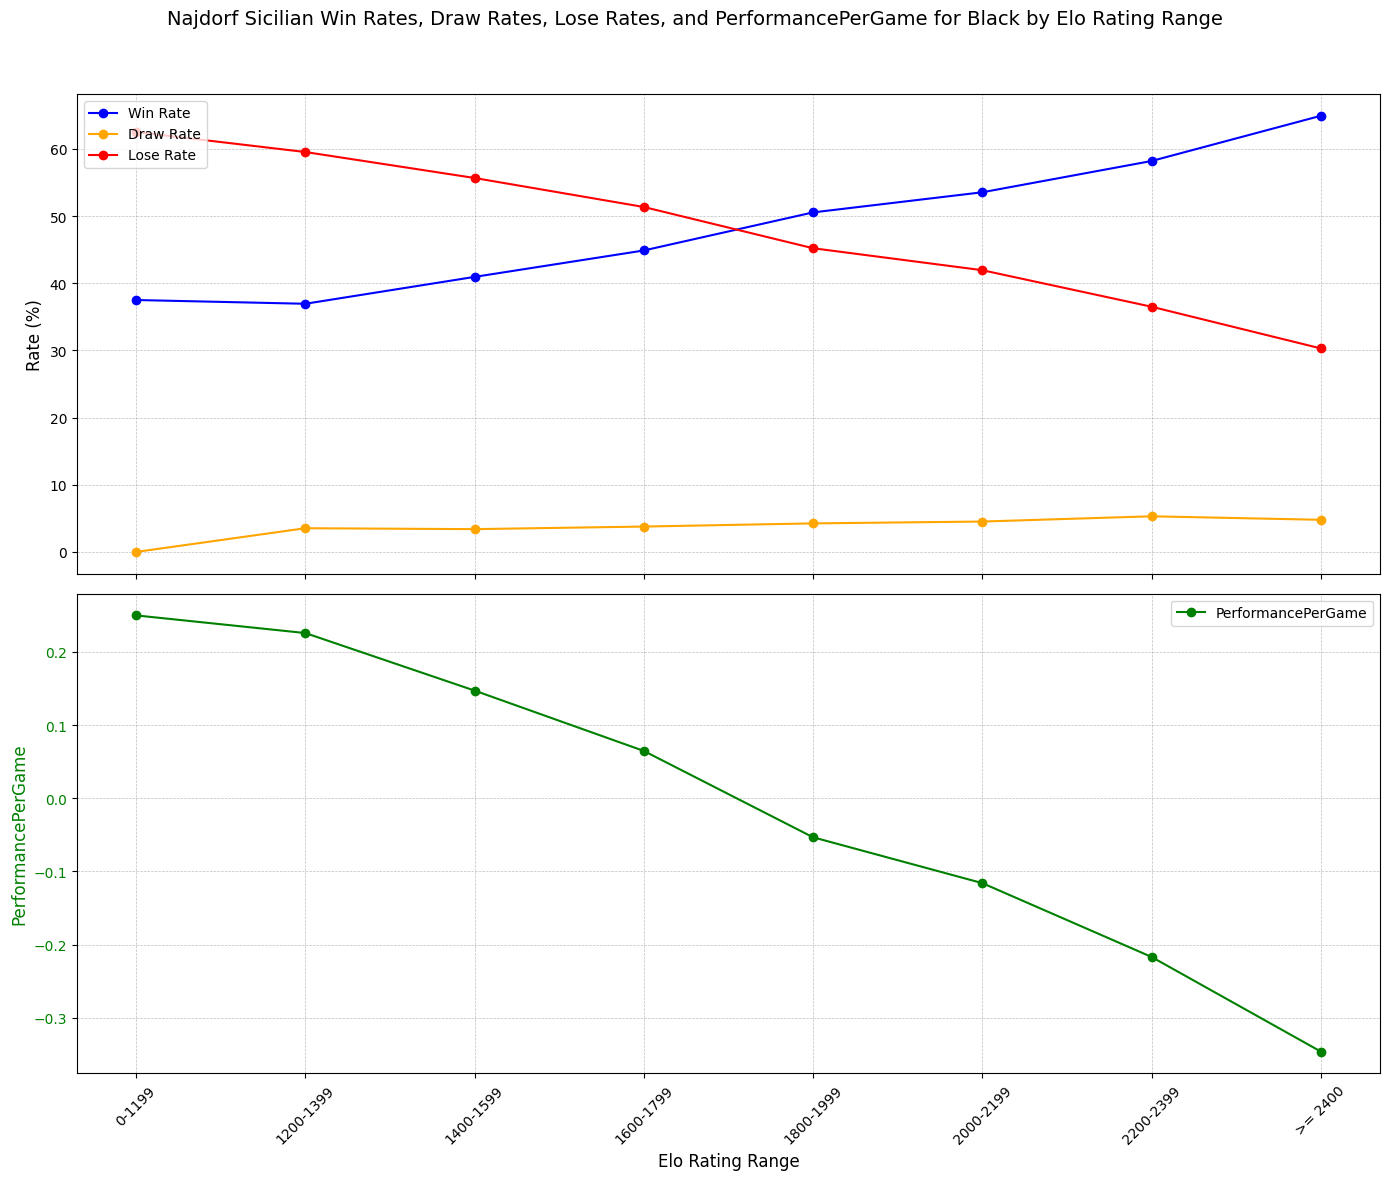

In [70]:
# Convert them to Pandas DataFrames for plotting
win_rate_pd = win_rate.toPandas()
performance_pd = performance_per_game.toPandas()

# Sort win_rate_pd and performance_pd by BlackEloCategory
win_rate_pd.sort_values(by='BlackEloCategory', inplace=True)
performance_pd.sort_values(by='BlackEloCategory', inplace=True)

# Calculate draw counts
draw_counts = (najdorf_df.filter(najdorf_df['Result'] == 0)
                        .groupBy('BlackEloCategory')
                        .agg(F.count('*').alias('DrawCount')))

# Calculate lose counts
lose_counts = (najdorf_df.filter(najdorf_df['Result'] == 1)
                        .groupBy('BlackEloCategory')
                        .agg(F.count('*').alias('LoseCount')))

# Join 
agg_counts = (total_games.join(win_counts, 'BlackEloCategory', 'outer')
                         .join(draw_counts, 'BlackEloCategory', 'outer')
                         .join(lose_counts, 'BlackEloCategory', 'outer')
                         .fillna(0))

# Calculate draw rate and lose rate
agg_counts = agg_counts.withColumn('DrawRate', F.col('DrawCount') / F.col('TotalGames') * 100)
agg_counts = agg_counts.withColumn('LoseRate', F.col('LoseCount') / F.col('TotalGames') * 100)

# Convert to Pandas DataFrame for plotting
agg_counts_pd = agg_counts.toPandas()

# Plotting win rates, draw rates, and lose rates
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), sharex=True)

# Plot win rates, draw rates, and lose rates on first subplot (ax1)
ax1.plot(win_rate_pd['BlackEloCategory'], win_rate_pd['WinRate'], marker='o', linestyle='-', color='b', label='Win Rate')
ax1.plot(agg_counts_pd['BlackEloCategory'], agg_counts_pd['DrawRate'], marker='o', linestyle='-', color='orange', label='Draw Rate')
ax1.plot(agg_counts_pd['BlackEloCategory'], agg_counts_pd['LoseRate'], marker='o', linestyle='-', color='r', label='Lose Rate')
ax1.set_ylabel('Rate (%)', size=12)
ax1.tick_params(axis='y')
ax1.legend(loc='upper left')

# Plot performance on second subplot (ax2)
ax2.plot(performance_pd['BlackEloCategory'], performance_pd['PerformancePerGame'], marker='o', linestyle='-', color='g', label='PerformancePerGame')
ax2.set_xlabel('Elo Rating Range', size=12)
ax2.set_ylabel('PerformancePerGame', size=12, color='g')
ax2.tick_params(axis='y', labelcolor='g')
ax2.legend(loc='upper right')

# Title
plt.suptitle('Najdorf Sicilian Win Rates, Draw Rates, Lose Rates, and PerformancePerGame for Black by Elo Rating Range', size=14)
plt.xticks(rotation=45)

# Grid and layout
ax1.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
ax2.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Some insights about Resignations and Draws

In [71]:
# Recreate the ELO grouping
df2 = df_games.withColumn('WhiteEloCategory', 
        F.when((F.col('WhiteElo') <= 1199), '0-1199')
        .when((F.col('WhiteElo') >= 1200) & (F.col('WhiteElo') < 1400), '1200-1399')
        .when((F.col('WhiteElo') >= 1400) & (F.col('WhiteElo') < 1600), '1400-1599')
        .when((F.col('WhiteElo') >= 1600) & (F.col('WhiteElo') < 1800), '1600-1799')
        .when((F.col('WhiteElo') >= 1800) & (F.col('WhiteElo') < 2000), '1800-1999')
        .when((F.col('WhiteElo') >= 2000) & (F.col('WhiteElo') < 2200), '2000-2199')
        .when((F.col('WhiteElo') >= 2200) & (F.col('WhiteElo') < 2400), '2200-2399')
        .when((F.col('WhiteElo') >= 2400), '>= 2400'))

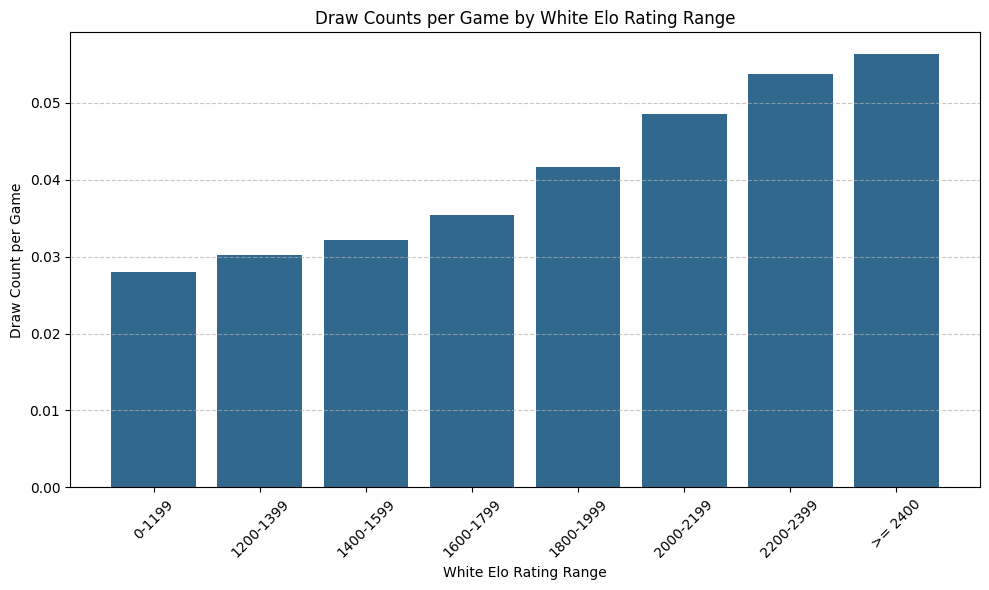

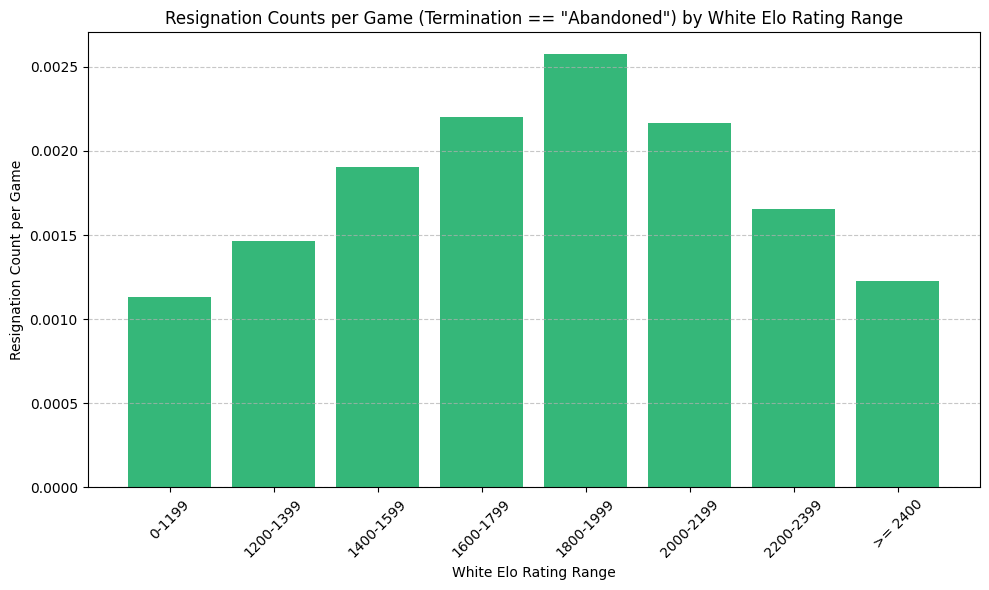

In [72]:
# Calculate total games per WhiteEloCategory
total_games = df2.groupBy('WhiteEloCategory').agg(F.count('*').alias('TotalGames'))

# Calculate draw counts per WhiteEloCategory
draw_counts = (df2.filter(df2['Result'] == 0)
                      .groupBy('WhiteEloCategory')
                      .agg(F.count('*').alias('DrawCount')))

# Calculate resignation counts (Termination == "Abandoned") per WhiteEloCategory
resignation_counts = (df2.filter(df2['Termination'] == "Abandoned")
                             .groupBy('WhiteEloCategory')
                             .agg(F.count('*').alias('ResignationCount')))

# Join with total games and calculate per game averages
draw_counts_per_game = (draw_counts.join(total_games, 'WhiteEloCategory')
                                   .withColumn('DrawCountPerGame', F.col('DrawCount') / F.col('TotalGames')))

resignation_counts_per_game = (resignation_counts.join(total_games, 'WhiteEloCategory')
                                                .withColumn('ResignationCountPerGame', F.col('ResignationCount') / F.col('TotalGames')))

# Convert to Pandas DataFrame for plotting
draw_counts_pd = draw_counts_per_game.toPandas()
resignation_counts_pd = resignation_counts_per_game.toPandas()

# Sort by WhiteEloCategory for consistent plotting
draw_counts_pd.sort_values(by='WhiteEloCategory', inplace=True)
resignation_counts_pd.sort_values(by='WhiteEloCategory', inplace=True)

# Define a color palette
colors = sns.color_palette('viridis', n_colors=2)  # Choose 2 colors from the 'viridis' palette

# Plotting draw counts per game
plt.figure(figsize=(10, 6))
plt.bar(draw_counts_pd['WhiteEloCategory'], draw_counts_pd['DrawCountPerGame'], color=colors[0])
plt.xlabel('White Elo Rating Range')
plt.ylabel('Draw Count per Game')
plt.title('Draw Counts per Game by White Elo Rating Range')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plotting resignation counts per game
plt.figure(figsize=(10, 6))
plt.bar(resignation_counts_pd['WhiteEloCategory'], resignation_counts_pd['ResignationCountPerGame'], color=colors[1])
plt.xlabel('White Elo Rating Range')
plt.ylabel('Resignation Count per Game')
plt.title('Resignation Counts per Game (Termination == "Abandoned") by White Elo Rating Range')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## The first graph is not surprising, but the second one it's very unexpected, more details on the report

### Correlation Matrix

In [46]:
df_games.printSchema()

root
 |-- Black: string (nullable = true)
 |-- TimeControlName: string (nullable = true)
 |-- White: string (nullable = true)
 |-- ECO: string (nullable = true)
 |-- Result: integer (nullable = true)
 |-- UTCDate: date (nullable = true)
 |-- UTCTime: timestamp (nullable = true)
 |-- WhiteElo: integer (nullable = true)
 |-- BlackElo: integer (nullable = true)
 |-- WhiteRatingDiff: double (nullable = true)
 |-- BlackRatingDiff: double (nullable = true)
 |-- Opening: string (nullable = true)
 |-- TimeControl: string (nullable = true)
 |-- Termination: string (nullable = true)
 |-- AN: string (nullable = true)
 |-- n_moves: integer (nullable = true)
 |-- w_opening_n_games: long (nullable = true)
 |-- b_opening_n_games: long (nullable = true)
 |-- w_opening_performance: long (nullable = true)
 |-- b_opening_performance: long (nullable = true)
 |-- w_timecontrol_n_games: long (nullable = true)
 |-- b_timecontrol_n_games: long (nullable = true)
 |-- w_timecontrol_performance: long (nullable =

In [31]:
# Dropping non-numerical features
df_games_num = df_games.drop('Black', 'TimeControlName', 'White', 'ECO', 'Result', 'UTCDate', 'UTCTime', 'Opening', 'TimeControl', 'Termination', 'AN')

In [27]:
features = df_games_num.schema.names

# Create VectorAssembler
vectorassembler = VectorAssembler(inputCols=features, outputCol='assemblerfeatures')
output_dataset = vectorassembler.transform(df_games_num)

# Calculate Pearson correlation matrix
pearsonCorr = Correlation.corr(output_dataset, 'assemblerfeatures', 'pearson').head()[0]

# Convert dense matrix into numpy array
correlation_array = pearsonCorr.toArray()

correlation_df = pd.DataFrame(
    correlation_array,
    index=features,
    columns=features
)


<Axes: >

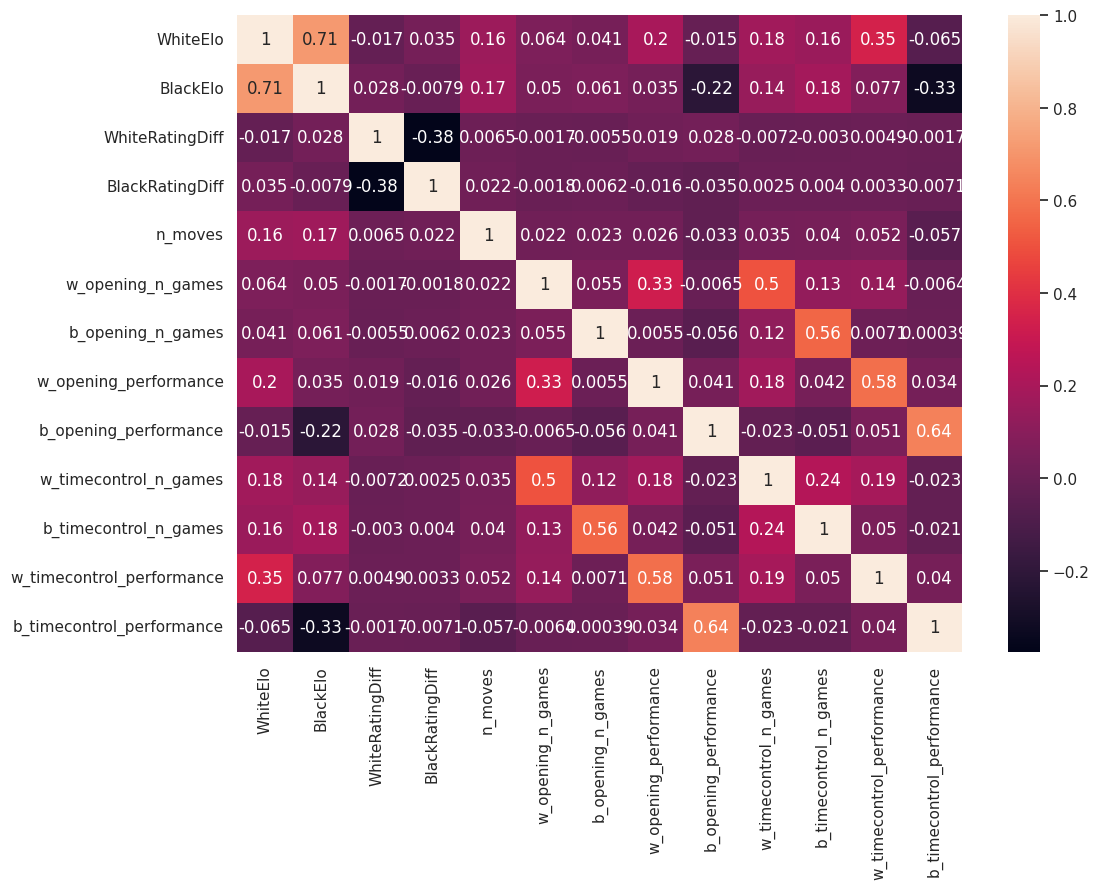

In [28]:
# plotting Correlation Matrix
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(correlation_df, annot=True)

In [32]:
df_classification = df_games_num.drop('BlackElo') 
# Momentarily dropping "BlackElo", more details on the report

# Classification

In [44]:
# I would have also liked to insert direct information about the Opening, however that would increase the dimensionality too much
# And that information is not absolutely necessary, since with w(b)_opening_performance(n_games), we should know all the info needed 

distinct_eco_count = df_games.select("ECO").distinct().count()
print(f"Distinct ECO values count: {distinct_eco_count}")


Distinct ECO values count: 493


#### The classification task has, as output value, the Result (-1, 0, 1) of a game given the same numerical features used for Matrix Correlation Analysis (except "BlackElo"), plus the One-Hot encoding of two categorical features: TimeControlName and Termination [=We are inserting TimeControlName, differently from ECO, for the additional information it could bring: Young low-rated players could easily upset stronger players in Bullet-like Time Controls (even with similar proficiencies in it)]

In [34]:
# 1. Indexing our Categorical variables of interest
indexer = StringIndexer(inputCols=['Termination', 'TimeControlName'], 
                        outputCols=['termination_index', 'timecontrol_index']).setHandleInvalid("skip")

# 2. Converting Indexed feature columns to One Hot Encoded
onehotecoded = OneHotEncoder(inputCols = ['termination_index', 'timecontrol_index'],\
                                      outputCols = ['termination_vect', 'timecontrol_vect'])
# Stages of the pipeline
stages = [indexer, onehotecoded]
pipeline = Pipeline(stages=stages)

# Applying Pipeline
df_games_encoded = pipeline.fit(df_games).transform(df_games)

In [30]:
# "almost" final
df_final = df_games_encoded.drop('Black', 'TimeControlName', 'White', 'ECO', 'UTCDate', 'UTCTime', 
                                      'Opening', 'TimeControl', 'Termination', 'AN', 'BlackElo')

In [71]:
df_final.printSchema()

root
 |-- Result: integer (nullable = true)
 |-- WhiteElo: integer (nullable = true)
 |-- WhiteRatingDiff: double (nullable = true)
 |-- BlackRatingDiff: double (nullable = true)
 |-- n_moves: integer (nullable = true)
 |-- w_opening_n_games: long (nullable = true)
 |-- b_opening_n_games: long (nullable = true)
 |-- w_opening_performance: long (nullable = true)
 |-- b_opening_performance: long (nullable = true)
 |-- w_timecontrol_n_games: long (nullable = true)
 |-- b_timecontrol_n_games: long (nullable = true)
 |-- w_timecontrol_performance: long (nullable = true)
 |-- b_timecontrol_performance: long (nullable = true)
 |-- termination_index: double (nullable = false)
 |-- timecontrol_index: double (nullable = false)
 |-- termination_vect: vector (nullable = true)
 |-- timecontrol_vect: vector (nullable = true)



In [74]:
df_final.show(1)

+------+--------+---------------+---------------+-------+-----------------+-----------------+---------------------+---------------------+---------------------+---------------------+-------------------------+-------------------------+-----------------+-----------------+----------------+----------------+
|Result|WhiteElo|WhiteRatingDiff|BlackRatingDiff|n_moves|w_opening_n_games|b_opening_n_games|w_opening_performance|b_opening_performance|w_timecontrol_n_games|b_timecontrol_n_games|w_timecontrol_performance|b_timecontrol_performance|termination_index|timecontrol_index|termination_vect|timecontrol_vect|
+------+--------+---------------+---------------+-------+-----------------+-----------------+---------------------+---------------------+---------------------+---------------------+-------------------------+-------------------------+-----------------+-----------------+----------------+----------------+
|     1|    1937|           16.0|          -15.0|     13|              335|             

##### Last step in preparation for the Classification Task: substitute Result == -1 (Black Won), with 2. Negative values aren't supported by output labels. 

In [31]:
df_final = df_final.withColumn('Result', when(df_final.Result == -1, 2).otherwise(df_final.Result))

In [32]:
# Splitting data into Training and Testing sets (70/30)
trainingData, testData = df_final.randomSplit([0.7, 0.3],seed=37)

In [33]:
# Selected Features
input_features = trainingData.schema.names 

# Removing target variable
input_features = [feat for feat in input_features if feat != 'Result']

# Converting Features columns to a single one using VectorAssembler
vectorassembler = VectorAssembler(inputCols = input_features, outputCol= 'assemblerfeatures')

# Scaling assembler features
featurescaler = MinMaxScaler(inputCol = 'assemblerfeatures', outputCol = 'features')

In [34]:
# Pipeline
pipeline_preprocessing = Pipeline(stages=[vectorassembler, featurescaler])

In [35]:
# Preprocess the training samples and apply the same pipeline model to the test set
model_preprossing = pipeline_preprocessing.fit(trainingData) 

X_y_train = model_preprossing.transform(trainingData) 
X_y_test = model_preprossing.transform(testData)

## Random Forest

### numTrees = 20

In [36]:
rf_n20 = RandomForestClassifier(labelCol='Result', featuresCol='features', numTrees=20)

# Fit RandomForestClassifier on training data
model_rf_n20 = rf_n20.fit(X_y_train)

In [37]:
# Predict using the trained RandomForestClassifier on X_y_test
pred_rf_n20 = model_rf_n20.transform(X_y_test)

In [38]:
# Evaluate the model 

eval_f1 = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='Result', metricName='f1')
print("RandomForest_n20", "f1", eval_f1.evaluate(pred_rf_n20))

eval_accuracy = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='Result', metricName='accuracy')
print("RandomForest_n20", "acc", eval_accuracy.evaluate(pred_rf_n20))

RandomForest_n20 f1 0.9576096809286033


RandomForest_n20 acc 0.9683792567924558


In [168]:
pred_rf_n20.printSchema()

root
 |-- Result: integer (nullable = true)
 |-- WhiteElo: integer (nullable = true)
 |-- WhiteRatingDiff: double (nullable = true)
 |-- BlackRatingDiff: double (nullable = true)
 |-- n_moves: integer (nullable = true)
 |-- w_opening_n_games: long (nullable = true)
 |-- b_opening_n_games: long (nullable = true)
 |-- w_opening_performance: long (nullable = true)
 |-- b_opening_performance: long (nullable = true)
 |-- w_timecontrol_n_games: long (nullable = true)
 |-- b_timecontrol_n_games: long (nullable = true)
 |-- w_timecontrol_performance: long (nullable = true)
 |-- b_timecontrol_performance: long (nullable = true)
 |-- termination_index: double (nullable = false)
 |-- timecontrol_index: double (nullable = false)
 |-- termination_vect: vector (nullable = true)
 |-- timecontrol_vect: vector (nullable = true)
 |-- assemblerfeatures: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)


In [39]:
# Prepare Resilient Distributed Dataset with prediction and true label pairs for evaluation (necessary for MulticlassMetrics)

predictionAndLabels_rf20 = pred_rf_n20.select("prediction", "Result").rdd.map(lambda row: (row.prediction, float(row.Result)))
print(predictionAndLabels_rf20.take(1))

[(1.0, 0.0)]


/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


<Axes: >

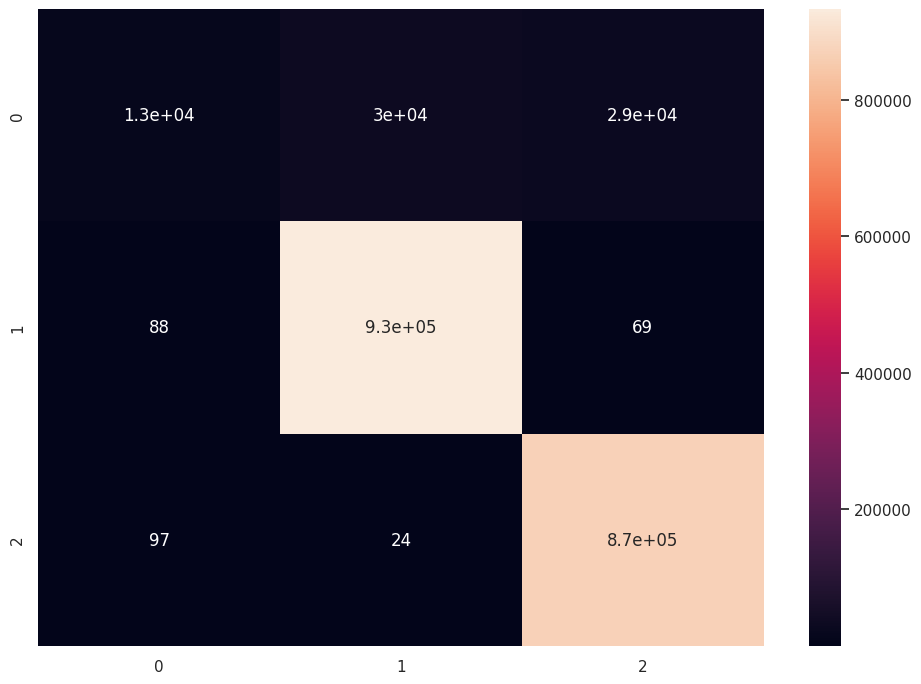

In [40]:
# Compute and visualize the confusion matrix for the Random Forest model (rf20)

metrics_rf20 = MulticlassMetrics(predictionAndLabels_rf20)

cfmx_rf20 = metrics_rf20.confusionMatrix()

cfarr_rf20 = cfmx_rf20.toArray()

confusionmatrix_rf20 = pd.DataFrame(
    cfarr_rf20
)

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(confusionmatrix_rf20, annot=True) 

In [41]:
# Extract true labels and predictions
y_true = pred_rf_n20.select("Result").rdd.flatMap(lambda x: x).collect()
y_pred = pred_rf_n20.select("prediction").rdd.flatMap(lambda x: x).collect()

# Generate classification report using the good old scikit-learn
report_rf = classification_report(y_true, y_pred, target_names=[str(label) for label in set(y_true)])

print(report_rf)

              precision    recall  f1-score   support

           0       0.99      0.18      0.30     71484
           1       0.97      1.00      0.98    932748
           2       0.97      1.00      0.98    869538

    accuracy                           0.97   1873770
   macro avg       0.97      0.72      0.75   1873770
weighted avg       0.97      0.97      0.96   1873770



## Logistic Regression

In [42]:
# Initialize LogisticRegression
lr = LogisticRegression(labelCol='Result', featuresCol='features', maxIter=50)

# Fit LogisticRegression on training data
model_lr = lr.fit(X_y_train)

# Predict using the trained LogisticRegression on X_test
pred_lr = model_lr.transform(X_y_test)

# Evaluate the model 
eval_f1 = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='Result', metricName='f1')
print("LogisticRegression", "f1", eval_f1.evaluate(pred_lr))

accuracy_evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='Result', metricName='accuracy')
print("LogisticRegression", "acc", accuracy_evaluator.evaluate(pred_lr))

LogisticRegression f1 0.9757012788512345


LogisticRegression acc 0.977883091307898


In [43]:
# Prepare prediction and label RDD for MulticlassMetrics
predictionAndLabels_lr = pred_lr.select("prediction", "Result").rdd.map(lambda row: (row.prediction, float(row.Result)))
print(predictionAndLabels_lr.take(1))

# Compute metrics
metrics_lr = MulticlassMetrics(predictionAndLabels_lr)

/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


[(0.0, 0.0)]


<Axes: >

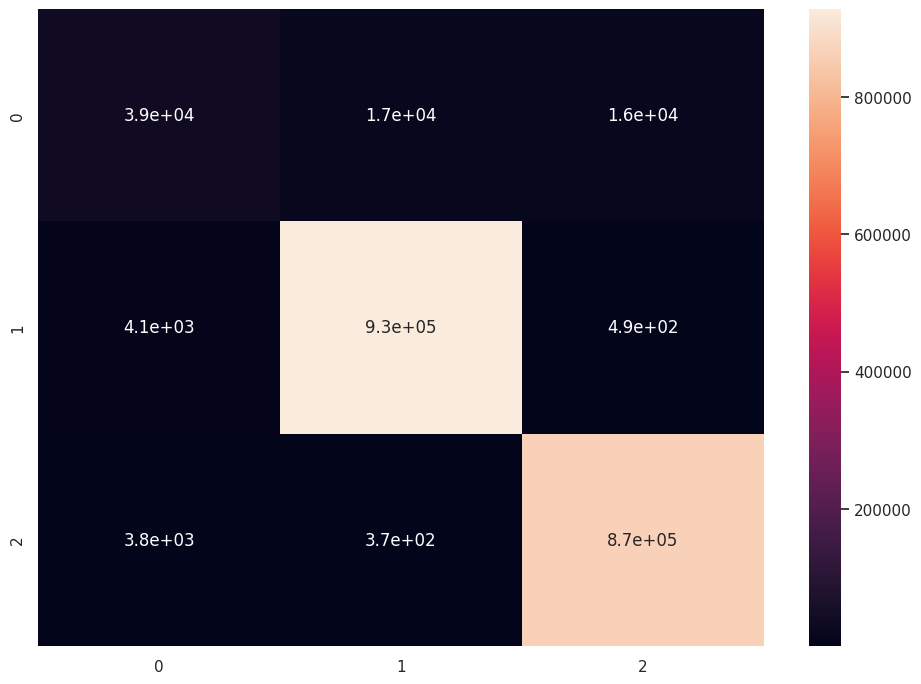

In [44]:
# Confusion matrix
cfmx_lr = metrics_lr.confusionMatrix()
cfarr_lr = cfmx_lr.toArray()

# Convert confusion matrix to DataFrame for visualization
confusionmatrix_lr = pd.DataFrame(cfarr_lr)

# Plot
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(confusionmatrix_lr, annot=True) 

In [ ]:
# Extract true labels and predictions
y_true = pred_lr.select("Result").rdd.flatMap(lambda x: x).collect()
y_pred = pred_lr.select("prediction").rdd.flatMap(lambda x: x).collect()

# Classification Report
report = classification_report(y_true, y_pred, target_names=[str(label) for label in set(y_true)])

In [ ]:
print(report)

## Second Approach: Did our first configuration rely too much on "WhiteRatingDiff" and "BlackRatingDiff"?

In [35]:
# Dropping "WhiteRatingDiff" and "BlackRatingDiff", and mantaining "BlackELO" (rest is the same as before)
df_final = df_games_encoded.drop('Black', 'TimeControlName', 'White', 'ECO', 'UTCDate', 'UTCTime', 
                                      'Opening', 'TimeControl', 'Termination', 'AN', 'WhiteRatingDiff', 'BlackRatingDiff')

In [36]:
# Mapping Result as before
df_final = df_final.withColumn('Result', when(df_final.Result == -1, 2).otherwise(df_final.Result))

In [37]:
# Splitting data into Training and Testing sets (70/30)
trainingData, testData = df_final.randomSplit([0.7, 0.3],seed=37)

In [38]:
# Selected Features
input_features = trainingData.schema.names 

# Removing target variable
input_features = [feat for feat in input_features if feat != 'Result']

# Converting Features columns to a single one using VectorAssembler
vectorassembler = VectorAssembler(inputCols = input_features, outputCol= 'assemblerfeatures')

# Scaling assembler features
featurescaler = MinMaxScaler(inputCol = 'assemblerfeatures', outputCol = 'features')

In [39]:
# Pipeline
pipeline_preprocessing = Pipeline(stages=[vectorassembler, featurescaler])

In [40]:
#Preprocess the training samples and apply the same pipeline model to the test set
model_preprossing = pipeline_preprocessing.fit(trainingData) 

X_y_train = model_preprossing.transform(trainingData) 
X_y_test = model_preprossing.transform(testData)

### Logistic Regression

In [41]:
# Initialize LogisticRegression
lr = LogisticRegression(labelCol='Result', featuresCol='features', maxIter=50)

# Fit LogisticRegression on training data
model_lr = lr.fit(X_y_train)

# Predict using the trained LogisticRegression on X_test
pred_lr = model_lr.transform(X_y_test)

# Evaluate the model 
eval_f1 = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='Result', metricName='f1')
print("LogisticRegression", "f1", eval_f1.evaluate(pred_lr))

accuracy_evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='Result', metricName='accuracy')
print("LogisticRegression", "acc", accuracy_evaluator.evaluate(pred_lr))

LogisticRegression f1 0.63176895996092


LogisticRegression acc 0.6413951552218256


In [42]:
# Prepare prediction and label RDD for MulticlassMetrics
predictionAndLabels_lr = pred_lr.select("prediction", "Result").rdd.map(lambda row: (row.prediction, float(row.Result)))
print(predictionAndLabels_lr.take(1))

# Compute metrics
metrics_lr = MulticlassMetrics(predictionAndLabels_lr)

/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


[(2.0, 0.0)]


<Axes: >

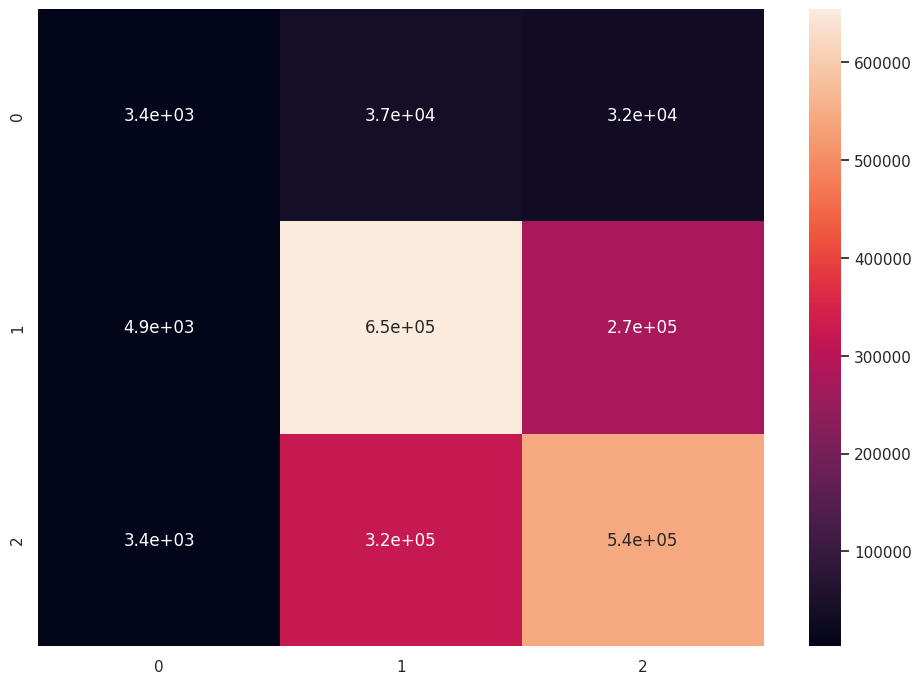

In [43]:
# Confusion matrix
cfmx_lr = metrics_lr.confusionMatrix()
cfarr_lr = cfmx_lr.toArray()

# Convert confusion matrix to DataFrame for visualization
confusionmatrix_lr = pd.DataFrame(cfarr_lr)

# Plot 
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(confusionmatrix_lr, annot=True) 

In [ ]:
# Extract true labels and predictions
y_true = pred_lr.select("Result").rdd.flatMap(lambda x: x).collect()
y_pred = pred_lr.select("prediction").rdd.flatMap(lambda x: x).collect()

# Generate classification report using scikit-learn
report = classification_report(y_true, y_pred, target_names=[str(label) for label in set(y_true)])

In [ ]:
print(report)

### Random Forest

In [44]:
# No more comments, nothing is different from before 

rf_n20 = RandomForestClassifier(labelCol='Result', featuresCol='features', numTrees=20)

model_rf_n20 = rf_n20.fit(X_y_train)

In [45]:
pred_rf_n20 = model_rf_n20.transform(X_y_test)

In [46]:
eval_f1 = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='Result', metricName='f1')
print("RandomForest_n20", "f1", eval_f1.evaluate(pred_rf_n20))

eval_accuracy = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='Result', metricName='accuracy')
print("RandomForest_n20", "acc", eval_accuracy.evaluate(pred_rf_n20))

RandomForest_n20 f1 0.7386283425711243


RandomForest_n20 acc 0.7531650095796175


/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


<Axes: >

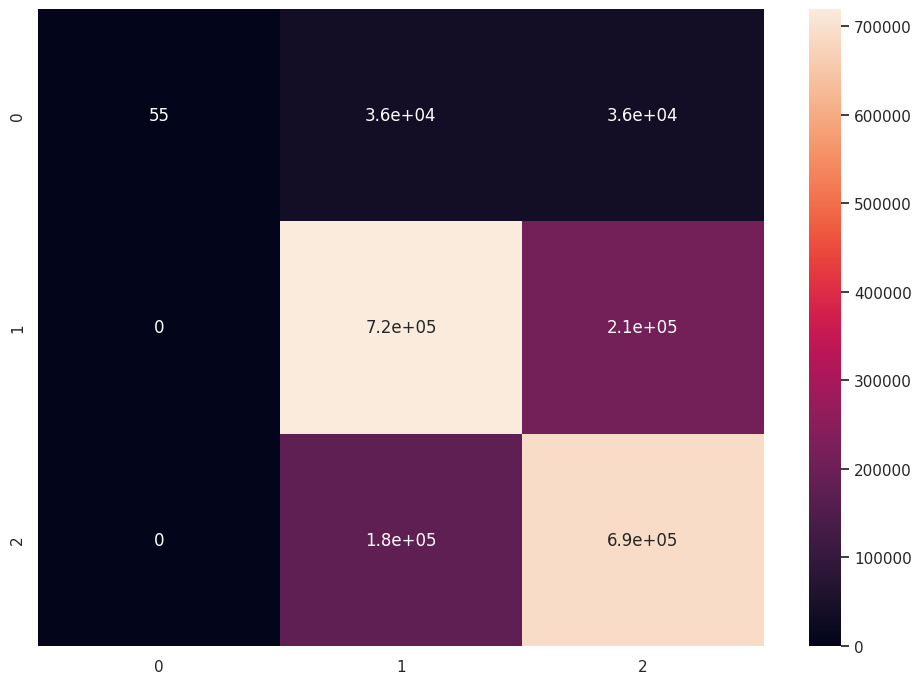

In [47]:
predictionAndLabels_rf20 = pred_rf_n20.select("prediction", "Result").rdd.map(lambda row: (row.prediction, float(row.Result)))

metrics_rf20 = MulticlassMetrics(predictionAndLabels_rf20)

cfmx_rf20 = metrics_rf20.confusionMatrix()

cfarr_rf20 = cfmx_rf20.toArray()

confusionmatrix_rf20 = pd.DataFrame(
    cfarr_rf20
)

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(confusionmatrix_rf20, annot=True) 

In [ ]:
y_true = pred_rf_n20.select("Result").rdd.flatMap(lambda x: x).collect()
y_pred = pred_rf_n20.select("prediction").rdd.flatMap(lambda x: x).collect()

report_rf = classification_report(y_true, y_pred, target_names=[str(label) for label in set(y_true)])

print(report_rf)